In [1]:
#Import the neccesary libraries
import warnings
warnings.filterwarnings('ignore')
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

In [14]:
df = pd.read_csv("processed.csv", parse_dates=['date'], index_col='date')
df =df.asfreq('D')
df =df[["quantity"]]
df.head()

quantity
date                
2009-12-01   26434.0
2009-12-02   31938.0
2009-12-03   50898.0
2009-12-04   21405.0
2009-12-05    5119.0

In [15]:
data = df.copy()
data["unique_id"]=1.0
data["ds"] = data.index
data.rename(columns={"quantity":"y"},inplace=True)
data.head()

y  unique_id         ds
date                                     
2009-12-01  26434.0        1.0 2009-12-01
2009-12-02  31938.0        1.0 2009-12-02
2009-12-03  50898.0        1.0 2009-12-03
2009-12-04  21405.0        1.0 2009-12-04
2009-12-05   5119.0        1.0 2009-12-05

In [16]:
# Using Nxitla libraries
#Data Split
# Calculate the index for the split
split_index = int(0.8 * len(data))

# Split the data
Y_train_df = data.iloc[:split_index]
Y_test_df = data.iloc[split_index:]   # Test data for January 2012

horizon = len(Y_test_df)

# SARIMAX

MAE: 9385.278937359777
MAPE: 0.4424611701513237
sMAPE: 39.864206864998216
R²: -0.22365772833245523


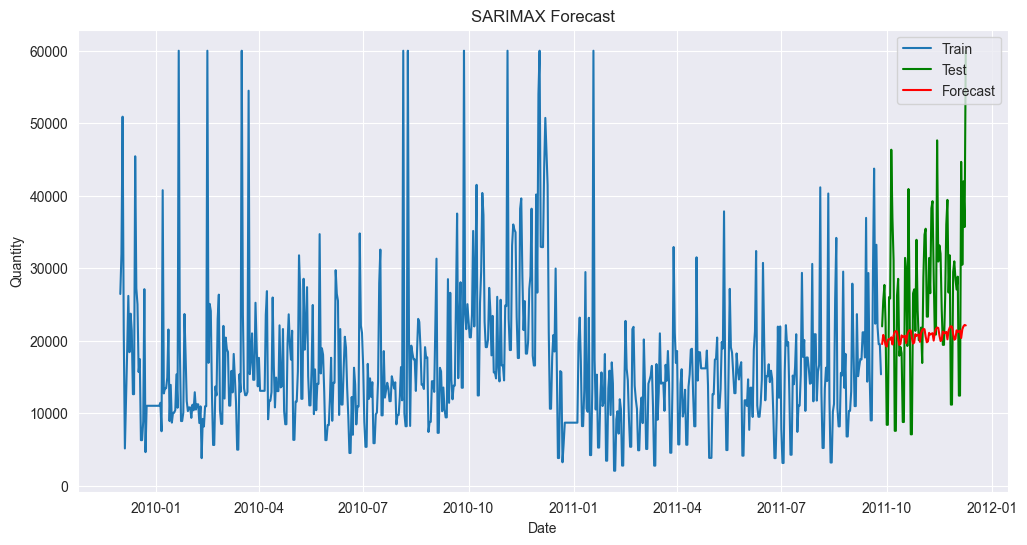

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with the date as the index and 'quantity' as the column

# Split data into train and test sets
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Define and fit the SARIMAX model
model = SARIMAX(train['quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fit_model = model.fit(disp=False)

# Forecast
n_forecast = len(test)
forecast = fit_model.get_forecast(steps=n_forecast)
forecast_index = test.index
forecast_values = forecast.predicted_mean

# Calculate MAE and MAPE
mae = mean_absolute_error(test['quantity'], forecast_values)
mape = mean_absolute_percentage_error(test['quantity'], forecast_values)

# Calculate sMAPE
def smape(a, f):
    return 100 * np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

smape_value = smape(test['quantity'].values, forecast_values.values)

# Calculate R²
r2 = r2_score(test['quantity'], forecast_values)

# Print the results
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'sMAPE: {smape_value}')
print(f'R²: {r2}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['quantity'], label='Train')
plt.plot(test.index, test['quantity'], label='Test', color='green')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('SARIMAX Forecast')
plt.legend()
plt.show()


In [17]:
ml_data = data.copy()
train_df = ml_data [:-30]
test_df = ml_data [-30:]

AutoARIMA - MAE: 11963.7620, MAPE: 37.4635%, sMAPE: 4610.8273%, R²: -1.0530
AutoETS - MAE: 8514.0500, MAPE: 35.7812%, sMAPE: 3063.9208%, R²: -0.0417
AutoCES - MAE: 10586.1776, MAPE: 37.9176%, sMAPE: 3923.3426%, R²: -0.3864
AutoTheta - MAE: 8597.1251, MAPE: 36.9655%, sMAPE: 3094.1638%, R²: -0.0430
SESOpt - MAE: 8482.2922, MAPE: 35.8735%, sMAPE: 3051.7420%, R²: -0.0360

The best model is AutoETS with a MAPE of 35.7812%


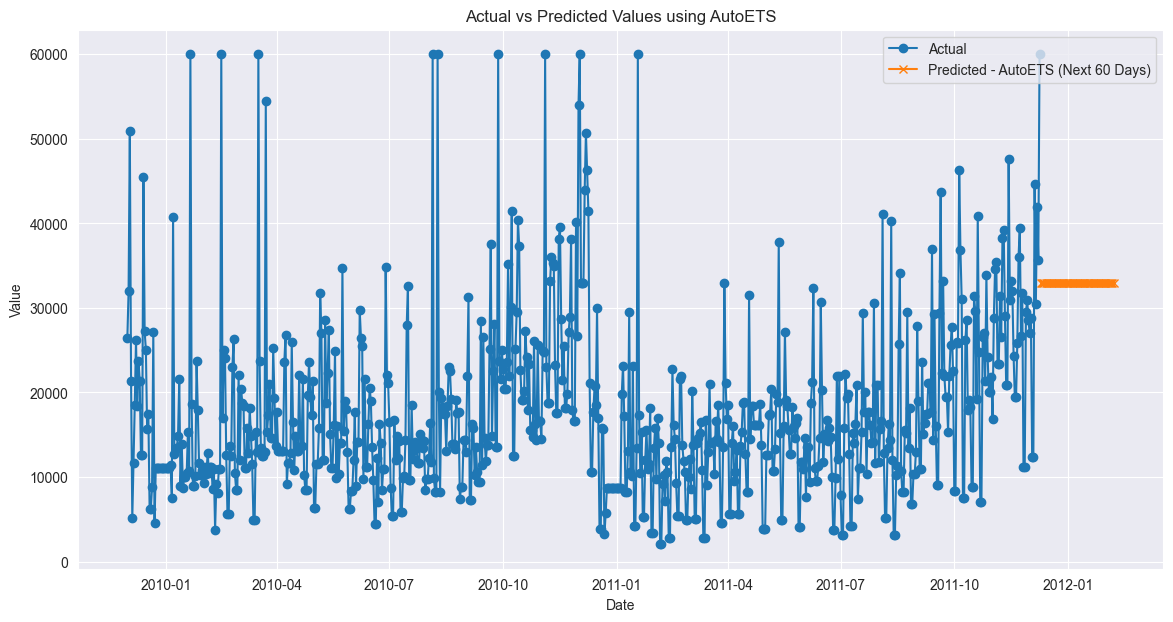


The best model is AutoETS with a MAPE of 35.7812%


In [7]:
import pandas as pd
import numpy as np
from statsforecast.models import AutoARIMA, AutoETS, AutoCES, AutoTheta, SimpleExponentialSmoothingOptimized
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Assuming you have defined train_df, test_df, and ml_data somewhere in your code

# Extract the 'y' series from train and test dataframes
train_series = train_df['y'].values
test_series = test_df['y'].values

# Define the models
models = {
    'AutoARIMA': AutoARIMA(season_length=12),
    'AutoETS': AutoETS(model='ZZZ', season_length=12),
    'AutoCES': AutoCES(model='Z', season_length=12),
    'AutoTheta': AutoTheta(season_length=12),
    'SESOpt': SimpleExponentialSmoothingOptimized()
}

# Initialize lists to store results
mape_scores = []
mae_scores = []
smape_scores = []
r2_scores = []
forecasts_dict = {}

def smape(a, f):
    return 100 * np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

# Train and evaluate each model
for name, model in models.items():
    model = model.fit(y=train_series)
    forecasts = model.predict(h=len(test_series))
    forecasts_dict[name] = forecasts['mean']
    
    # Calculate MAE, MAPE, sMAPE, and R²
    mae = mean_absolute_error(test_series, forecasts['mean'])
    mape = mean_absolute_percentage_error(test_series, forecasts['mean'])
    smape_value = smape(test_series, forecasts['mean'])
    r2 = r2_score(test_series, forecasts['mean'])
    
    mae_scores.append((name, mae))
    mape_scores.append((name, mape))
    smape_scores.append((name, smape_value))
    r2_scores.append((name, r2))
    
    print(f"{name} - MAE: {mae:.4f}, MAPE: {mape:.4%}, sMAPE: {smape_value:.4%}, R²: {r2:.4f}")

# Select the best model based on MAPE
best_model_name, best_mape = min(mape_scores, key=lambda x: x[1])
best_model = models[best_model_name]

print(f"\nThe best model is {best_model_name} with a MAPE of {best_mape:.4%}")

# Train the best model on the entire dataset
best_model = best_model.fit(y=ml_data['y'].values)

# Predict the next 60 days
future_forecasts = best_model.predict(h=60)

# Combine the historical data with the forecast data for plotting
combined_df = ml_data.copy()
future_df = pd.DataFrame({
    'ds': pd.date_range(start=ml_data['ds'].max() + pd.Timedelta(days=1), periods=60, freq='D'),
    'y': np.nan
})
combined_df = pd.concat([combined_df, future_df], ignore_index=True)
combined_df['forecast'] = np.nan
combined_df.loc[ml_data.shape[0]:, 'forecast'] = future_forecasts['mean']

# Plot actual vs predicted values for the historical period and future forecast
plt.figure(figsize=(14, 7))

# Plot the entire dataset
plt.plot(combined_df['ds'], combined_df['y'], label='Actual', marker='o')

# Plot the future forecasts
plt.plot(
    combined_df['ds'],
    combined_df['forecast'],
    label=f'Predicted - {best_model_name} (Next 60 Days)',
    marker='x',
)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'Actual vs Predicted Values using {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nThe best model is {best_model_name} with a MAPE of {best_mape:.4%}")


## Machine learning methods

RandomForest - MAE: 6590.8060, MAPE: 25.0480%, sMAPE: 2250.8261%, R²: 0.3129
XGBoost - MAE: 8885.4902, MAPE: 36.1673%, sMAPE: 3150.1568%, R²: -0.1510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 679, number of used features: 18
[LightGBM] [Info] Start training from score 16877.740795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

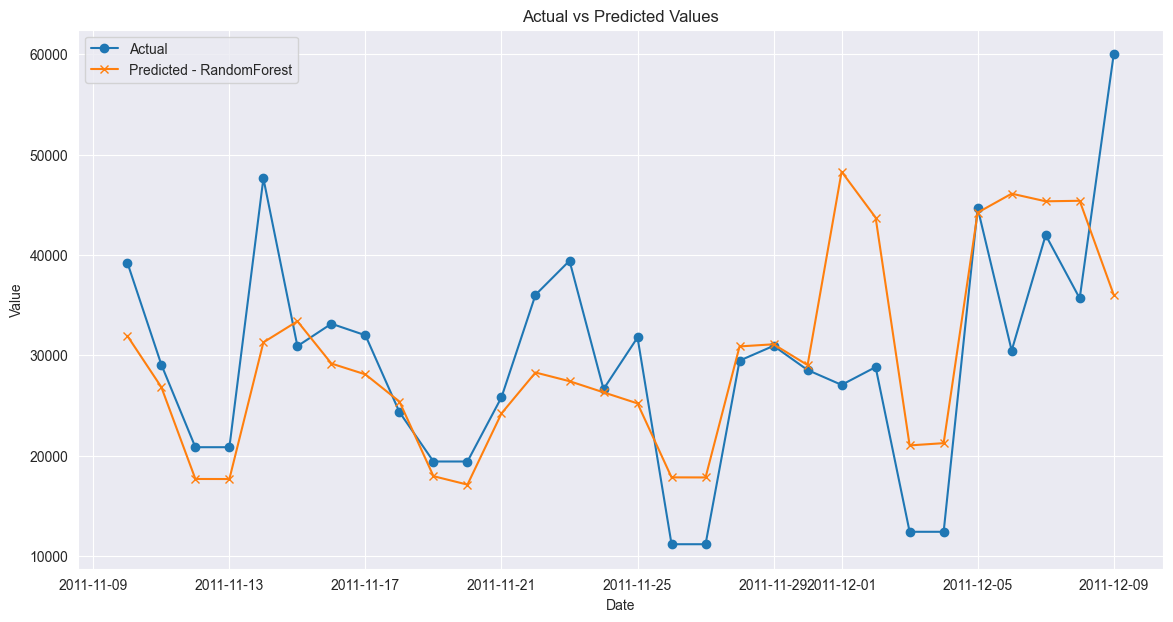

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import holidays

# Function to create date features
def create_date_features(data):
    data["month"] = data.index.month
    data["day_of_month"] = data.index.day
    data["is_month_start"] = data.index.is_month_start.astype(int)
    data["is_month_end"] = data.index.is_month_end.astype(int)
    data["day_of_year"] = data.index.dayofyear
    data["week_of_year"] = data.index.isocalendar().week
    data["day_of_week"] = data.index.dayofweek + 1
    data["year"] = data.index.year
    data["is_weekend"] = (data.index.weekday >= 5).astype(int)
    data['is_spring'] = data['month'].isin([3, 4, 5]).astype(int)
    data['is_summer'] = data['month'].isin([6, 7, 8]).astype(int)
    data['is_fall'] = data['month'].isin([9, 10, 11]).astype(int)
    data['is_winter'] = data['month'].isin([12, 1, 2]).astype(int)
    data['sin_day'] = np.sin(2 * np.pi * data.index.dayofweek / 7)
    data['cos_day'] = np.cos(2 * np.pi * data.index.dayofweek / 7)
    return data

# Add holiday feature
uk_holidays = holidays.CountryHoliday('UK')

# Create date features
rml_data = create_date_features(data.copy())
rml_data['is_public_holiday'] = rml_data.index.to_series().apply(lambda date: 1 if date in uk_holidays else 0)

# Define Features and Models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100)
}

# Specify the features to be used in the model
date_features = ['month', 'day_of_month', 'is_month_start', 'is_month_end',
                 'day_of_year', 'week_of_year', 'day_of_week', 'year',
                 'is_weekend', 'is_spring', 'is_summer', 'is_fall', 'is_winter',
                 'sin_day', 'cos_day', 'is_public_holiday']

# Prepare training data
def create_lagged_features(data, lags):
    for lag in lags:
        data[f'lag_{lag}'] = data['y'].shift(lag)
    return data

lags = [7, 14, 30]
rml_data = create_lagged_features(rml_data, lags).dropna()

X = rml_data[date_features + [f'lag_{lag}' for lag in lags]]
y = rml_data['y']

# Split data into train and test sets
train_X = X[:-30]
train_y = y[:-30]
test_X = X[-30:]
test_y = y[-30:]

# Initialize lists to store results
mape_scores = {}
mae_scores = {}
smape_scores = {}
r2_scores = {}
predictions = {}

def smape(a, f):
    return 100 * np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(train_X, train_y)
    predictions[model_name] = model.predict(test_X)
    
    # Calculate MAE, MAPE, sMAPE, and R²
    mae = mean_absolute_error(test_y, predictions[model_name])
    mape = mean_absolute_percentage_error(test_y, predictions[model_name])
    smape_value = smape(test_y, predictions[model_name])
    r2 = r2_score(test_y, predictions[model_name])
    
    mae_scores[model_name] = mae
    mape_scores[model_name] = mape
    smape_scores[model_name] = smape_value
    r2_scores[model_name] = r2
    
    print(f"{model_name} - MAE: {mae:.4f}, MAPE: {mape:.4%}, sMAPE: {smape_value:.4%}, R²: {r2:.4f}")

# Select the best model based on MAPE
best_model_name = min(mape_scores, key=mape_scores.get)
print(f"\nThe best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]:.4%}")

# Retrain the best model on the entire dataset
best_model = models[best_model_name]
best_model.fit(X, y)

# Predict the next 30 days
future_X = X[-30:]  # Assuming that you want to predict the next 30 days using the same features
future_predictions = best_model.predict(future_X)

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_y.index, test_y, label='Actual', marker='o')
plt.plot(test_y.index, predictions[best_model_name], label=f'Predicted - {best_model_name}', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import holidays

# Function to create date features
def create_date_features(data):
    data["month"] = data.index.month
    data["day_of_month"] = data.index.day
    data["is_month_start"] = data.index.is_month_start.astype(int)
    data["is_month_end"] = data.index.is_month_end.astype(int)
    data["day_of_year"] = data.index.dayofyear
    data["week_of_year"] = data.index.isocalendar().week
    data["day_of_week"] = data.index.dayofweek + 1
    data["year"] = data.index.year
    data["is_weekend"] = (data.index.weekday >= 5).astype(int)
    data['is_spring'] = data['month'].isin([3, 4, 5]).astype(int)
    data['is_summer'] = data['month'].isin([6, 7, 8]).astype(int)
    data['is_fall'] = data['month'].isin([9, 10, 11]).astype(int)
    data['is_winter'] = data['month'].isin([12, 1, 2]).astype(int)
    data['sin_day'] = np.sin(2 * np.pi * data.index.dayofweek / 7)
    data['cos_day'] = np.cos(2 * np.pi * data.index.dayofweek / 7)
    return data

# Add holiday feature
uk_holidays = holidays.CountryHoliday('UK')

# Create date features
rml_data = create_date_features(data.copy())
rml_data['is_public_holiday'] = rml_data.index.to_series().apply(lambda date: 1 if date in uk_holidays else 0)

# Define Features and Models
date_features = ['month', 'day_of_month', 'is_month_start', 'is_month_end',
                 'day_of_year', 'week_of_year', 'day_of_week', 'year',
                 'is_weekend', 'is_spring', 'is_summer', 'is_fall', 'is_winter',
                 'sin_day', 'cos_day', 'is_public_holiday']

# Prepare training data
def create_lagged_features(data, lags):
    for lag in lags:
        data[f'lag_{lag}'] = data['y'].shift(lag)
    return data

lags = [7, 14, 30]
rml_data = create_lagged_features(rml_data, lags).dropna()

X = rml_data[date_features + [f'lag_{lag}' for lag in lags]]
y = rml_data['y']

# Split data into train and test sets
train_X = X[:-30]
train_y = y[:-30]
test_X = X[-30:]
test_y = y[-30:]

# Define parameter grids for each model
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'num_leaves': [31, 40, 50],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

# Initialize lists to store results
mae_scores = {}
mape_scores = {}
smape_scores = {}
r2_scores = {}
predictions = {}

def smape(a, f):
    return 100 * np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

# Train and predict using each model with grid search
for model_name, model in {'RandomForest': RandomForestRegressor(), 
                          'XGBoost': XGBRegressor(objective='reg:squarederror'), 
                          'LightGBM': lgb.LGBMRegressor()}.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring='neg_mean_absolute_percentage_error')
    grid_search.fit(train_X, train_y)
    best_params = grid_search.best_params_
    predictions[model_name] = grid_search.predict(test_X)
    
    # Calculate MAE, MAPE, sMAPE, and R²
    mae = mean_absolute_error(test_y, predictions[model_name])
    mape = mean_absolute_percentage_error(test_y, predictions[model_name])
    smape_value = smape(test_y, predictions[model_name])
    r2 = r2_score(test_y, predictions[model_name])
    
    mae_scores[model_name] = mae
    mape_scores[model_name] = mape
    smape_scores[model_name] = smape_value
    r2_scores[model_name] = r2
    
    print(f"{model_name} - Best Params: {best_params}, MAE: {mae:.4f}, MAPE: {mape:.4%}, sMAPE: {smape_value:.4%}, R²: {r2:.4f}")

# Select the Best Model based on MAPE
best_model_name = min(mape_scores, key=mape_scores.get)
print(f"\nThe best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]:.4%}")

# Retrain the best model on the entire dataset with best parameters
best_model = {'RandomForest': RandomForestRegressor(**param_grids['RandomForest']),
              'XGBoost': XGBRegressor(objective='reg:squarederror', **param_grids['XGBoost']),
              'LightGBM': lgb.LGBMRegressor(**param_grids['LightGBM'])}[best_model_name]
best_model.fit(X, y)

# Predict the next 30 days
future_X = X[-30:]  # Assuming that you want to predict the next 30 days using the same features
future_predictions = best_model.predict(future_X)

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_y.index, test_y, label='Actual', marker='o')
plt.plot(test_y.index, predictions[best_model_name], label=f'Predicted - {best_model_name}', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


RandomForest - Best Params: {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 200}, MAE: 6012.6525, MAPE: 22.9921%, sMAPE: 2098.2865%, R²: 0.4309
XGBoost - Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}, MAE: 7268.6938, MAPE: 29.9416%, sMAPE: 2443.4104%, R²: 0.1074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 452, number of used features: 16
[LightGBM] [Info] Start training from score 17558.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

InvalidParameterError: The 'max_depth' parameter of RandomForestRegressor must be an int in the range [1, inf) or None. Got [None, 10, 20, 30] instead.

RandomForest - MAE: 6768.9630, MAPE: 26.0099%, sMAPE: 2311.5971%, R²: 0.3016
XGBoost - MAE: 8885.4902, MAPE: 36.1673%, sMAPE: 3150.1568%, R²: -0.1510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 679, number of used features: 18
[LightGBM] [Info] Start training from score 16877.740795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

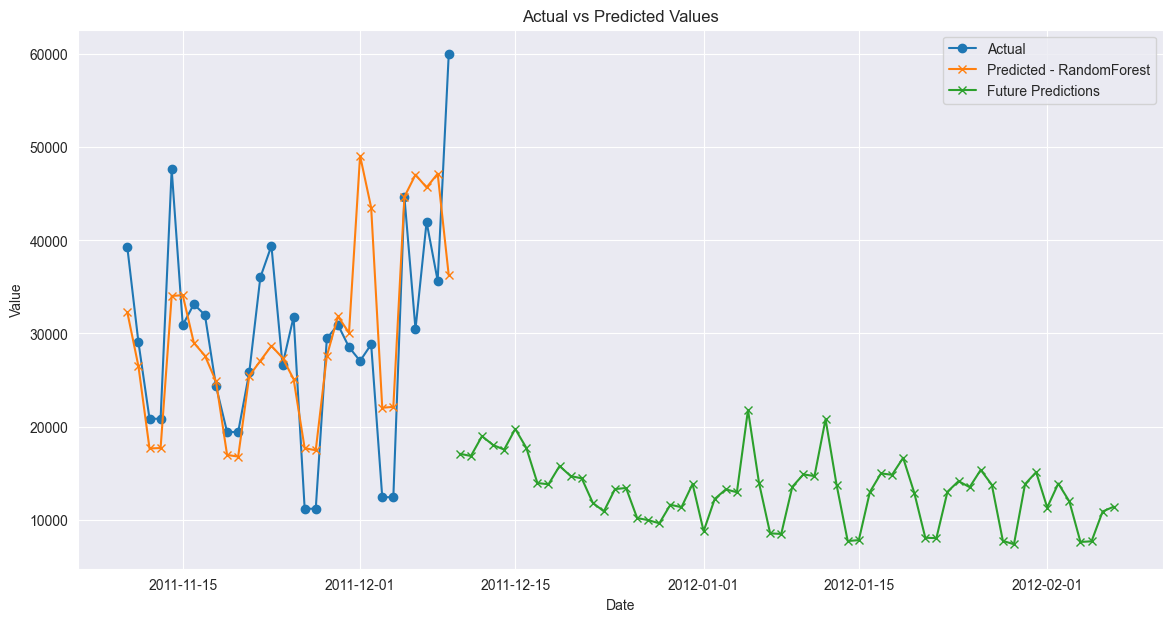

In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import holidays

# Function to create date features
def create_date_features(data):
    data["month"] = data.index.month
    data["day_of_month"] = data.index.day
    data["is_month_start"] = data.index.is_month_start.astype(int)
    data["is_month_end"] = data.index.is_month_end.astype(int)
    data["day_of_year"] = data.index.dayofyear
    data["week_of_year"] = data.index.isocalendar().week
    data["day_of_week"] = data.index.dayofweek + 1
    data["year"] = data.index.year
    data["is_weekend"] = (data.index.weekday >= 5).astype(int)
    data['is_spring'] = data['month'].isin([3, 4, 5]).astype(int)
    data['is_summer'] = data['month'].isin([6, 7, 8]).astype(int)
    data['is_fall'] = data['month'].isin([9, 10, 11]).astype(int)
    data['is_winter'] = data['month'].isin([12, 1, 2]).astype(int)
    data['sin_day'] = np.sin(2 * np.pi * data.index.dayofweek / 7)
    data['cos_day'] = np.cos(2 * np.pi * data.index.dayofweek / 7)
    return data

# Add holiday feature
uk_holidays = holidays.CountryHoliday('UK')

# Create date features
rml_data = create_date_features(data.copy())
rml_data['is_public_holiday'] = rml_data.index.to_series().apply(lambda date: 1 if date in uk_holidays else 0)

# Define Features and Models
date_features = ['month', 'day_of_month', 'is_month_start', 'is_month_end',
                 'day_of_year', 'week_of_year', 'day_of_week', 'year',
                 'is_weekend', 'is_spring', 'is_summer', 'is_fall', 'is_winter',
                 'sin_day', 'cos_day', 'is_public_holiday']

# Prepare training data
def create_lagged_features(data, lags):
    for lag in lags:
        data[f'lag_{lag}'] = data['y'].shift(lag)
    return data

lags = [7, 14, 30]
rml_data = create_lagged_features(rml_data, lags).dropna()

X = rml_data[date_features + [f'lag_{lag}' for lag in lags]]
y = rml_data['y']

# Split data into train and test sets
train_X = X[:-30]
train_y = y[:-30]
test_X = X[-30:]
test_y = y[-30:]

# Initialize models with default parameters
models = {
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror'),
    'LightGBM': lgb.LGBMRegressor()
}

# Initialize lists to store results
mae_scores = {}
mape_scores = {}
smape_scores = {}
r2_scores = {}
predictions = {}

def smape(a, f):
    return 100 * np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

# Train and predict using each model without grid search
for model_name, model in models.items():
    model.fit(train_X, train_y)
    predictions[model_name] = model.predict(test_X)
    
    # Calculate MAE, MAPE, sMAPE, and R²
    mae = mean_absolute_error(test_y, predictions[model_name])
    mape = mean_absolute_percentage_error(test_y, predictions[model_name])
    smape_value = smape(test_y, predictions[model_name])
    r2 = r2_score(test_y, predictions[model_name])
    
    mae_scores[model_name] = mae
    mape_scores[model_name] = mape
    smape_scores[model_name] = smape_value
    r2_scores[model_name] = r2
    
    print(f"{model_name} - MAE: {mae:.4f}, MAPE: {mape:.4%}, sMAPE: {smape_value:.4%}, R²: {r2:.4f}")

# Select the Best Model based on MAPE
best_model_name = min(mape_scores, key=mape_scores.get)
print(f"\nThe best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]:.4%}")

# Retrain the best model on the entire dataset with default parameters
best_model = models[best_model_name]
best_model.fit(X, y)

# Predict the next 60 days
future_dates = pd.date_range(start=X.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
future_data = pd.DataFrame(index=future_dates)
future_data = create_date_features(future_data)
future_data['is_public_holiday'] = future_data.index.to_series().apply(lambda date: 1 if date in uk_holidays else 0)

# Initialize the lagged features with previous values
for lag in lags:
    future_data[f'lag_{lag}'] = np.nan

# Iterative prediction for the next 60 days
for i, date in enumerate(future_dates):
    if i == 0:
        lagged_features = [np.nan] * len(lags)  # No lagged values for the first date
    else:
        lagged_features = future_data.iloc[i-1][[f'lag_{lag}' for lag in lags]].values
    
    # Create the feature vector for the current date
    current_features = future_data.loc[date, date_features + [f'lag_{lag}' for lag in lags]].values.reshape(1, -1)
    future_data.at[date, 'Predicted'] = best_model.predict(current_features)[0]
    
    # Update lagged features for future iterations
    for j, lag in enumerate(lags):
        if date - pd.Timedelta(days=lag) in future_data.index:
            future_data.at[date, f'lag_{lag}'] = future_data.at[date, 'Predicted']

# Combine actual and predicted values
combined_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted': future_data['Predicted']
}).set_index('Date')

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_y.index, test_y, label='Actual', marker='o')
plt.plot(test_y.index, predictions[best_model_name], label=f'Predicted - {best_model_name}', marker='x')
plt.plot(combined_df.index, combined_df['Predicted'], label='Future Predictions', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


RandomForest - Best Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}, MAE: 5896.6065, MAPE: 22.5613%, sMAPE: 2069.6203%, R²: 0.4554
XGBoost - Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}, MAE: 7268.6938, MAPE: 29.9416%, sMAPE: 2443.4104%, R²: 0.1074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 452, number of used features: 16
[LightGBM] [Info] Start training from score 17558.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

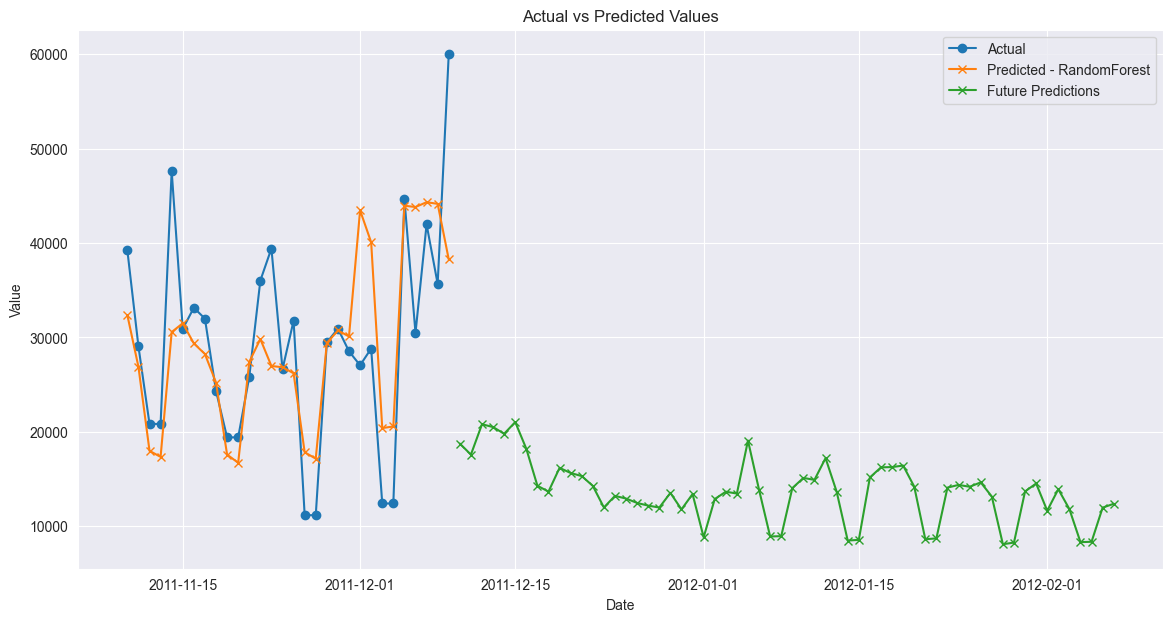

In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import holidays

# Function to create date features
def create_date_features(data):
    data["month"] = data.index.month
    data["day_of_month"] = data.index.day
    data["is_month_start"] = data.index.is_month_start.astype(int)
    data["is_month_end"] = data.index.is_month_end.astype(int)
    data["day_of_year"] = data.index.dayofyear
    data["week_of_year"] = data.index.isocalendar().week
    data["day_of_week"] = data.index.dayofweek + 1
    data["year"] = data.index.year
    data["is_weekend"] = (data.index.weekday >= 5).astype(int)
    data['is_spring'] = data['month'].isin([3, 4, 5]).astype(int)
    data['is_summer'] = data['month'].isin([6, 7, 8]).astype(int)
    data['is_fall'] = data['month'].isin([9, 10, 11]).astype(int)
    data['is_winter'] = data['month'].isin([12, 1, 2]).astype(int)
    data['sin_day'] = np.sin(2 * np.pi * data.index.dayofweek / 7)
    data['cos_day'] = np.cos(2 * np.pi * data.index.dayofweek / 7)
    return data

# Add holiday feature
uk_holidays = holidays.CountryHoliday('UK')

# Create date features
rml_data = create_date_features(data.copy())
rml_data['is_public_holiday'] = rml_data.index.to_series().apply(lambda date: 1 if date in uk_holidays else 0)

# Define Features and Models
date_features = ['month', 'day_of_month', 'is_month_start', 'is_month_end',
                 'day_of_year', 'week_of_year', 'day_of_week', 'year',
                 'is_weekend', 'is_spring', 'is_summer', 'is_fall', 'is_winter',
                 'sin_day', 'cos_day', 'is_public_holiday']

# Prepare training data
def create_lagged_features(data, lags):
    for lag in lags:
        data[f'lag_{lag}'] = data['y'].shift(lag)
    return data

lags = [7, 14, 30]
rml_data = create_lagged_features(rml_data, lags).dropna()

X = rml_data[date_features + [f'lag_{lag}' for lag in lags]]
y = rml_data['y']

# Split data into train and test sets
train_X = X[:-30]
train_y = y[:-30]
test_X = X[-30:]
test_y = y[-30:]

# Define parameter grids for each model
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'num_leaves': [31, 40, 50],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

# Initialize lists to store results
mae_scores = {}
mape_scores = {}
smape_scores = {}
r2_scores = {}
predictions = {}

def smape(a, f):
    return 100 * np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

# Train and predict using each model with grid search
best_params = {}

for model_name, model in {'RandomForest': RandomForestRegressor(), 
                          'XGBoost': XGBRegressor(objective='reg:squarederror'), 
                          'LightGBM': lgb.LGBMRegressor()}.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring='neg_mean_absolute_percentage_error')
    grid_search.fit(train_X, train_y)
    best_params[model_name] = grid_search.best_params_
    predictions[model_name] = grid_search.predict(test_X)
    
    # Calculate MAE, MAPE, sMAPE, and R²
    mae = mean_absolute_error(test_y, predictions[model_name])
    mape = mean_absolute_percentage_error(test_y, predictions[model_name])
    smape_value = smape(test_y, predictions[model_name])
    r2 = r2_score(test_y, predictions[model_name])
    
    mae_scores[model_name] = mae
    mape_scores[model_name] = mape
    smape_scores[model_name] = smape_value
    r2_scores[model_name] = r2
    
    print(f"{model_name} - Best Params: {best_params[model_name]}, MAE: {mae:.4f}, MAPE: {mape:.4%}, sMAPE: {smape_value:.4%}, R²: {r2:.4f}")

# Select the Best Model based on MAPE
best_model_name = min(mape_scores, key=mape_scores.get)
print(f"\nThe best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]:.4%}")

# Retrain the best model on the entire dataset with best parameters
best_model = {'RandomForest': RandomForestRegressor(**best_params['RandomForest']),
              'XGBoost': XGBRegressor(objective='reg:squarederror', **best_params['XGBoost']),
              'LightGBM': lgb.LGBMRegressor(**best_params['LightGBM'])}[best_model_name]

best_model.fit(X, y)

# Predict the next 60 days
future_dates = pd.date_range(start=X.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
future_data = pd.DataFrame(index=future_dates)
future_data = create_date_features(future_data)
future_data['is_public_holiday'] = future_data.index.to_series().apply(lambda date: 1 if date in uk_holidays else 0)

# Initialize the lagged features with previous values
for lag in lags:
    future_data[f'lag_{lag}'] = np.nan

# Iterative prediction for the next 60 days
for i, date in enumerate(future_dates):
    if i == 0:
        lagged_features = [np.nan] * len(lags)  # No lagged values for the first date
    else:
        lagged_features = future_data.iloc[i-1][[f'lag_{lag}' for lag in lags]].values
    
    # Create the feature vector for the current date
    current_features = future_data.loc[date, date_features + [f'lag_{lag}' for lag in lags]].values.reshape(1, -1)
    future_data.at[date, 'Predicted'] = best_model.predict(current_features)[0]
    
    # Update lagged features for future iterations
    for j, lag in enumerate(lags):
        if date - pd.Timedelta(days=lag) in future_data.index:
            future_data.at[date, f'lag_{lag}'] = future_data.at[date, 'Predicted']

# Combine actual and predicted values
combined_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted': future_data['Predicted']
}).set_index('Date')

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_y.index, test_y, label='Actual', marker='o')
plt.plot(test_y.index, predictions[best_model_name], label=f'Predicted - {best_model_name}', marker='x')
plt.plot(combined_df.index, combined_df['Predicted'], label='Future Predictions', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


LightGBM - MAE: 13185.3659, MAPE: 41.6267%, sMAPE: 5725.3475%, R²: -1.2476
XGBoost - MAE: 14326.5257, MAPE: 43.3551%, sMAPE: 6022.3743%, R²: -1.8292
RandomForest - MAE: 14540.7520, MAPE: 46.7737%, sMAPE: 6402.0133%, R²: -1.5190
LinearRegression - MAE: 19219.0472, MAPE: 67.0475%, sMAPE: 10816.2803%, R²: -3.2185

The best model is LightGBM with a MAPE of 41.6267%


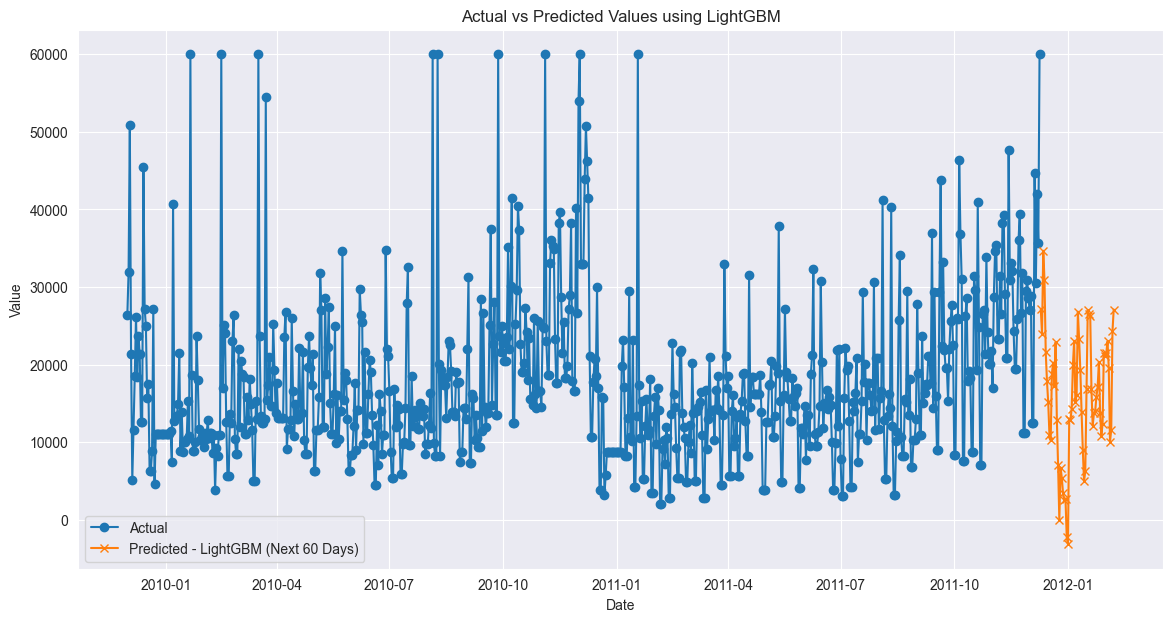


The best model is LightGBM with a MAPE of 41.6267%


In [11]:
import pandas as pd
import numpy as np
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# Function to calculate sMAPE
def smape(a, f):
    return 100 * np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

# Assuming you have defined train_df, test_df, and ml_data somewhere in your code

# Convert 'ds' column to datetime if necessary
train_df['ds'] = pd.to_datetime(train_df['ds'])
test_df['ds'] = pd.to_datetime(test_df['ds'])
ml_data['ds'] = pd.to_datetime(ml_data['ds'])

# Define the models
models = {
    'LightGBM': lgb.LGBMRegressor(verbosity=-1),
    'XGBoost': xgb.XGBRegressor(verbosity=0),
    'RandomForest': RandomForestRegressor(),
    'LinearRegression': LinearRegression()
}

# Initialize lists to store results
mae_scores = []
mape_scores = []
smape_scores = []
r2_scores = []
forecasts_dict = {}

# Define MLForecast object
def create_forecast_object(model):
    return MLForecast(
        models=[model],
        freq='D',
        lags=[7, 14],
        lag_transforms={
            1: [ExpandingMean()],
            7: [RollingMean(window_size=28)]
        },
        date_features=['dayofweek'],
        target_transforms=[Differences([1])]
    )

# Train and evaluate each model
for name, model in models.items():
    fcst = create_forecast_object(model)
    fcst.fit(train_df)
    
    # Make predictions for the test set
    predictions = fcst.predict(len(test_df))
    predictions.columns = ['unique_id', 'ds', name]
    forecasts_dict[name] = predictions
    
    # Align forecast with test_df to calculate MAE, MAPE, sMAPE, and R²
    aligned_forecasts = predictions[name].values[:len(test_df)]
    
    mae = mean_absolute_error(test_df['y'], aligned_forecasts)
    mape = mean_absolute_percentage_error(test_df['y'], aligned_forecasts)
    smape_value = smape(test_df['y'], aligned_forecasts)
    r2 = r2_score(test_df['y'], aligned_forecasts)
    
    mae_scores.append((name, mae))
    mape_scores.append((name, mape))
    smape_scores.append((name, smape_value))
    r2_scores.append((name, r2))
    
    print(f"{name} - MAE: {mae:.4f}, MAPE: {mape:.4%}, sMAPE: {smape_value:.4%}, R²: {r2:.4f}")

# Select the best model based on MAPE
best_model_name, best_mape = min(mape_scores, key=lambda x: x[1])
best_model = models[best_model_name]

print(f"\nThe best model is {best_model_name} with a MAPE of {best_mape:.4%}")

# Train the best model on the entire dataset
best_fcst = create_forecast_object(best_model)
best_fcst.fit(ml_data)

# Predict the next 60 days
future_forecasts = best_fcst.predict(60)
future_forecasts.columns = ['unique_id', 'ds', best_model_name]

# Combine the historical data with the forecast data for plotting
combined_df = ml_data.copy()
future_df = pd.DataFrame({
    'ds': pd.date_range(start=ml_data['ds'].max() + pd.Timedelta(days=1), periods=60, freq='D'),
    'y': np.nan
})
combined_df = pd.concat([combined_df, future_df], ignore_index=True)
combined_df['forecast'] = np.nan
combined_df.loc[ml_data.shape[0]:, 'forecast'] = future_forecasts[best_model_name].values

# Plot actual vs predicted values for the historical period and future forecast
plt.figure(figsize=(14, 7))

# Plot the entire dataset
plt.plot(combined_df['ds'], combined_df['y'], label='Actual', marker='o')

# Plot the future forecasts
plt.plot(
    combined_df['ds'],
    combined_df['forecast'],
    label=f'Predicted - {best_model_name} (Next 60 Days)',
    marker='x',
)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'Actual vs Predicted Values using {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nThe best model is {best_model_name} with a MAPE of {best_mape:.4%}")


# Deep Learning

Seed set to 1
Seed set to 1
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.985     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
10.9 K    Non-trainable params
2.6 M     Total params
10.371    Total estimated model params size (MB)


NHITS - MAE: 8553.8970, MAPE: 25.1987%, sMAPE: 3022.6248%, R²: -0.1820


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 120 K  | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
607 K     Trainable params
0         Non-trainable params
607 K     Total params
2.428     Total estimated model params size (MB)


NBEATS - MAE: 8024.9363, MAPE: 23.7422%, sMAPE: 2893.3603%, R²: -0.0639


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LSTM - MAE: 13667.2739, MAPE: 42.7853%, sMAPE: 5378.9179%, R²: -1.2450

The best model is NBEATS with a MAPE of 23.7422%



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
10.9 K    Non-trainable params
2.6 M     Total params
10.371    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

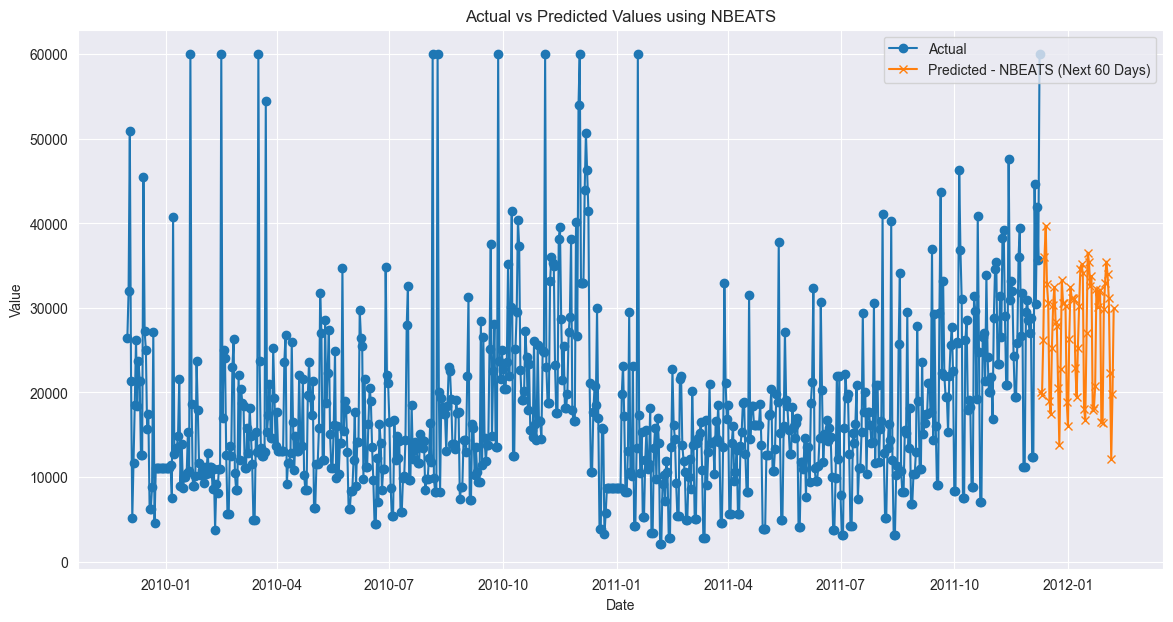

The best model is NBEATS with a MAPE of 23.7422%


In [20]:
import pandas as pd
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, LSTM
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# Function to calculate sMAPE
def smape(a, f):
    return 100 * np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

# Assuming you have defined train_df, test_df, and ml_data somewhere in your code

# Define the models and their respective parameters
nhits_params = {
    'h': 60,
    'input_size': 30,
    'max_steps': 50
}

nbeats_params = {
    'h': 60,
    'input_size': 30,
    'max_steps': 50
}

lstm_params = {
    'h': 60,
    'input_size': 30,
    'max_steps': 50
}

# Initialize the models
nhits_model = NHITS(**nhits_params)
nbeats_model = NBEATS(**nbeats_params)
lstm_model = LSTM(**lstm_params)

# Train each model on the training data and evaluate on test data
models = [nhits_model, nbeats_model, lstm_model]
model_names = ['NHITS', 'NBEATS', 'LSTM']
mae_scores = []
mape_scores = []
smape_scores = []
r2_scores = []

for model, name in zip(models, model_names):
    nf = NeuralForecast(models=[model], freq='D')
    nf.fit(train_df)
    
    # Create future dataframe for the test set to match expected combinations
    future_test_df = nf.make_future_dataframe()
    
    # Make predictions for the test set
    forecasts = nf.predict()
    forecasts = forecasts.set_index('ds')
    
    # Align forecast with test_df to calculate MAE, MAPE, sMAPE, and R²
    aligned_forecasts = forecasts[name].iloc[:len(test_df)].values
    
    mae = mean_absolute_error(test_df['y'], aligned_forecasts)
    mape = mean_absolute_percentage_error(test_df['y'], aligned_forecasts)
    smape_value = smape(test_df['y'], aligned_forecasts)
    r2 = r2_score(test_df['y'], aligned_forecasts)
    
    mae_scores.append((name, mae))
    mape_scores.append((name, mape))
    smape_scores.append((name, smape_value))
    r2_scores.append((name, r2))
    
    print(f"{name} - MAE: {mae:.4f}, MAPE: {mape:.4%}, sMAPE: {smape_value:.4%}, R²: {r2:.4f}")

# Select the best model based on MAPE
best_model_name, best_mape = min(mape_scores, key=lambda x: x[1])
best_model = None

if best_model_name == 'NHITS':
    best_model = NHITS(**nhits_params)
elif best_model_name == 'NBEATS':
    best_model = NBEATS(**nbeats_params)
elif best_model_name == 'LSTM':
    best_model = LSTM(**lstm_params)
    
print(f"\nThe best model is {best_model_name} with a MAPE of {best_mape:.4%}")

# Train the best model on the entire dataset
nf_best_model = NeuralForecast(models=[best_model], freq='D')
nf_best_model.fit(ml_data)

# Create a future dataframe for the next 60 days
future_df = nf_best_model.make_future_dataframe()

# Predict the next 60 days
future_forecasts = nf_best_model.predict()
future_forecasts = future_forecasts.set_index('ds')

# Combine the historical data with the forecast data for plotting
combined_df = pd.concat([ml_data, future_df], ignore_index=True)
combined_df['forecast'] = np.nan
combined_df.loc[ml_data.shape[0]:, 'forecast'] = future_forecasts[best_model_name].values

# Plot actual vs predicted values for the historical period and future forecast
plt.figure(figsize=(14, 7))

# Plot the entire dataset
plt.plot(combined_df['ds'], combined_df['y'], label='Actual', marker='o')

# Plot the future forecasts
plt.plot(
    combined_df['ds'],
    combined_df['forecast'],
    label=f'Predicted - {best_model_name} (Next 60 Days)',
    marker='x',
)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'Actual vs Predicted Values using {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()

print(f"The best model is {best_model_name} with a MAPE of {best_mape:.4%}")


Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.985     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


NHITS - MAE: 8553.8970, MAPE: 25.1987%, sMAPE: 3022.6248%, R²: -0.1820



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.292    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.600    Total estimated model params size (MB)


NHITS - MAE: 6550.0122, MAPE: 28.2111%, sMAPE: 2351.1027%, R²: 0.3017


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


NHITS - MAE: 22359460234.8667, MAPE: 83338846.2731%, sMAPE: 19999.8500%, R²: -7206783200545.9990



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
10.9 K    Non-trainable params
2.6 M     Total params
10.371    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


NBEATS - MAE: 8024.9363, MAPE: 23.7422%, sMAPE: 2893.3603%, R²: -0.0639



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.7 M  | train
-------------------------------------------------------
2.6 M     Trainable params
14.5 K    Non-trainable params
2.7 M     Total params
10.631    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.7 M  | train
-------------------------------------------------------
2.7 M     Trainable params
18.2 K    Non-trainable params
2.7 M     Total params
10.892    Total estimated model params size (MB)


NBEATS - MAE: 10300.3857, MAPE: 51.9554%, sMAPE: 3510.3436%, R²: -0.3364


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 120 K  | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
607 K     Trainable params
0         Non-trainable params
607 K     Total params
2.428     Total estimated model params size (MB)


NBEATS - MAE: 165244216657940.8125, MAPE: 665833778746.3702%, sMAPE: 20000.0000%, R²: -228223176820652638208.0000


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 120 K  | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
607 K     Trainable params
0         Non-trainable params
607 K     Total params
2.428     Total estimated model params size (MB)


LSTM - MAE: 13667.2739, MAPE: 42.7853%, sMAPE: 5378.9179%, R²: -1.2450


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 1.8 M  | train
4 | context_adapter | Linear        | 180 K  | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.966     Total estimated model params size (MB)


LSTM - MAE: 15192.4656, MAPE: 46.6252%, sMAPE: 6205.7077%, R²: -1.7035


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LSTM - MAE: 15814.2839, MAPE: 48.1629%, sMAPE: 6564.0039%, R²: -1.9085
The best model is NBEATS with a MAPE of 23.7422% and best parameters: {'h': 60, 'input_size': 30, 'max_steps': 50, 'learning_rate': 0.001}



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
10.9 K    Non-trainable params
2.6 M     Total params
10.371    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

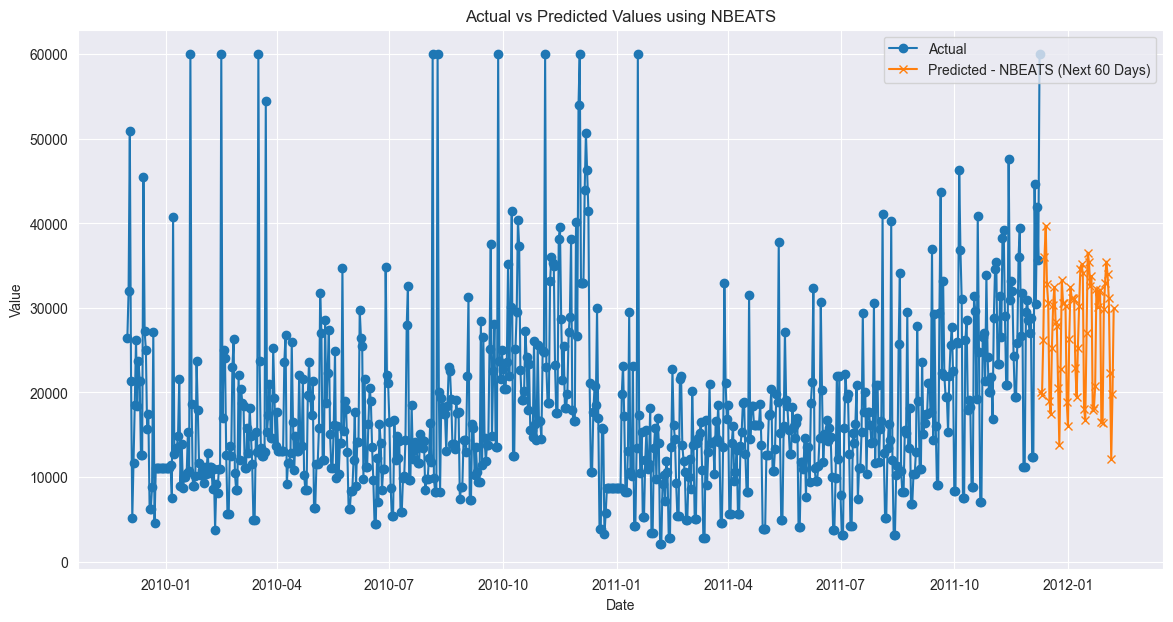

The best model is NBEATS with a MAPE of 23.7422% and best parameters: {'h': 60, 'input_size': 30, 'max_steps': 50, 'learning_rate': 0.001}


In [19]:
import pandas as pd
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, LSTM
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# Function to calculate sMAPE
def smape(a, f):
    return 100 * np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

# Assuming you have defined train_df, test_df, and ml_data somewhere in your code

# Define the parameter grids for manual fine-tuning
nhits_param_grid = [
    {'h': 60, 'input_size': 30, 'max_steps': 50, 'learning_rate': 0.001},
    {'h': 60, 'input_size': 60, 'max_steps': 100, 'learning_rate': 0.01},
    {'h': 60, 'input_size': 90, 'max_steps': 150, 'learning_rate': 0.1},
]

nbeats_param_grid = [
    {'h': 60, 'input_size': 30, 'max_steps': 50, 'learning_rate': 0.001},
    {'h': 60, 'input_size': 60, 'max_steps': 100, 'learning_rate': 0.01},
    {'h': 60, 'input_size': 90, 'max_steps': 150, 'learning_rate': 0.1},
]

lstm_param_grid = [
    {'h': 60, 'input_size': 30, 'max_steps': 50, 'learning_rate': 0.001, 'encoder_n_layers': 2, 'encoder_hidden_size': 200},
    {'h': 60, 'input_size': 60, 'max_steps': 100, 'learning_rate': 0.01, 'encoder_n_layers': 2, 'encoder_hidden_size': 200},
    {'h': 60, 'input_size': 90, 'max_steps': 150, 'learning_rate': 0.1, 'encoder_n_layers': 3, 'encoder_hidden_size': 300},
]

# Initialize the models
nhits_model = NHITS(h=60, input_size=30)
nbeats_model = NBEATS(h=60, input_size=30)
lstm_model = LSTM(h=60, input_size=30)

# Train and evaluate each model with different hyperparameters
models = [nhits_model, nbeats_model, lstm_model]
param_grids = [nhits_param_grid, nbeats_param_grid, lstm_param_grid]
model_names = ['NHITS', 'NBEATS', 'LSTM']
mape_scores = []
mae_scores = []
smape_scores = []
r2_scores = []

for model, param_grid, name in zip(models, param_grids, model_names):
    for params in param_grid:
        if name == 'NHITS':
            model = NHITS(**params)
        elif name == 'NBEATS':
            model = NBEATS(**params)
        elif name == 'LSTM':
            model = LSTM(**params)
            
        nf = NeuralForecast(models=[model], freq='D')
        nf.fit(train_df)
        
        # Make predictions for the test set
        forecasts = nf.predict()
        forecasts = forecasts.set_index('ds')
        
        # Align forecast with test_df to calculate MAE, MAPE, sMAPE, and R²
        aligned_forecasts = forecasts[name].iloc[:len(test_df)].values
        
        mae = mean_absolute_error(test_df['y'], aligned_forecasts)
        mape = mean_absolute_percentage_error(test_df['y'], aligned_forecasts)
        smape_value = smape(test_df['y'], aligned_forecasts)
        r2 = r2_score(test_df['y'], aligned_forecasts)
        
        mae_scores.append((name, mae, params))
        mape_scores.append((name, mape, params))
        smape_scores.append((name, smape_value, params))
        r2_scores.append((name, r2, params))
        
        print(f"{name} - MAE: {mae:.4f}, MAPE: {mape:.4%}, sMAPE: {smape_value:.4%}, R²: {r2:.4f}")

# Select the best model based on MAPE
best_model_name, best_mape, best_params = min(mape_scores, key=lambda x: x[1])

if best_model_name == 'NHITS':
    best_model = NHITS(**best_params)
elif best_model_name == 'NBEATS':
    best_model = NBEATS(**best_params)
elif best_model_name == 'LSTM':
    best_model = LSTM(**best_params)
    
print(f"The best model is {best_model_name} with a MAPE of {best_mape:.4%} and best parameters: {best_params}")

# Train the best model on the entire dataset
nf_best_model = NeuralForecast(models=[best_model], freq='D')
nf_best_model.fit(ml_data)

# Create a future dataframe for the next 60 days
future_df = nf_best_model.make_future_dataframe()

# Predict the next 60 days
future_forecasts = nf_best_model.predict()
future_forecasts = future_forecasts.set_index('ds')

# Combine the historical data with the forecast data for plotting
combined_df = pd.concat([ml_data, future_df], ignore_index=True)
combined_df['forecast'] = np.nan
combined_df.loc[ml_data.shape[0]:, 'forecast'] = future_forecasts[best_model_name].values

# Plot actual vs predicted values for the historical period and future forecast
plt.figure(figsize=(14, 7))

# Plot the entire dataset
plt.plot(combined_df['ds'], combined_df['y'], label='Actual', marker='o')

# Plot the future forecasts
plt.plot(
    combined_df['ds'],
    combined_df['forecast'],
    label=f'Predicted - {best_model_name} (Next 60 Days)',
    marker='x',
)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'Actual vs Predicted Values using {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()

print(f"The best model is {best_model_name} with a MAPE of {best_mape:.4%} and best parameters: {best_params}")


# Prophet

12:47:20 - cmdstanpy - INFO - Chain [1] start processing
12:47:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:47:22 - cmdstanpy - INFO - Chain [1] start processing
12:47:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 0.29
MAE: 6979.0
sMAPE: 24.69
R²: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

12:47:28 - cmdstanpy - INFO - Chain [1] start processing
12:47:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0  6 days  41495637.46  6441.71  5943.83  0.46   0.43   0.35      1.00
1  7 days  49255180.50  7018.20  6789.82  0.48   0.43   0.38      1.00
2  8 days  44304632.23  6656.17  6336.77  0.44   0.36   0.35      1.00
3  9 days  33444414.34  5783.11  5558.39  0.40   0.23   0.32      1.00
4 10 days  60565928.03  7782.41  7205.92  0.42   0.28   0.36      0.83
MAPE: 0.3
MAE: 6492.4
sMAPE: 26.68
R²: 0.31


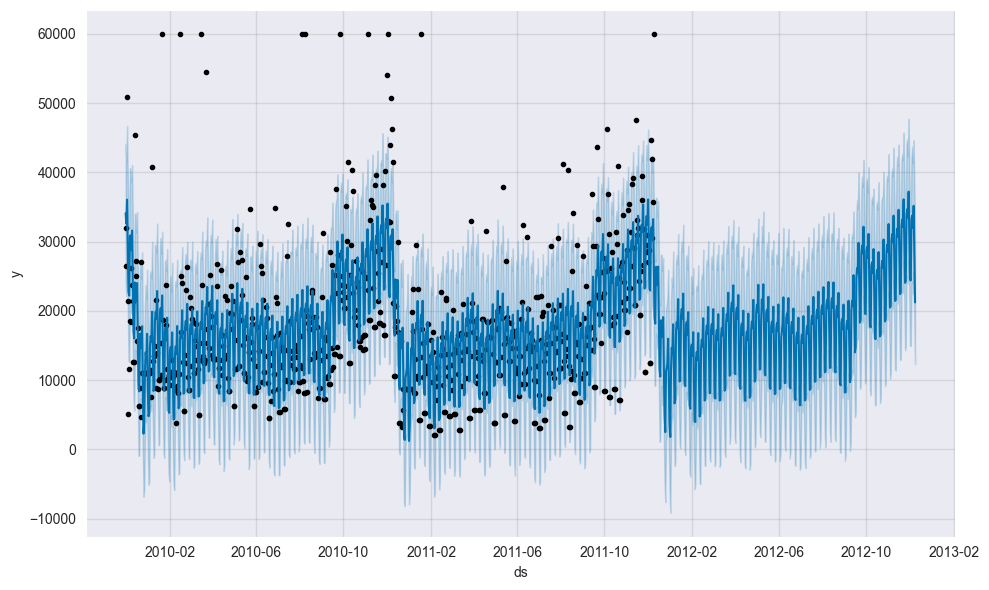

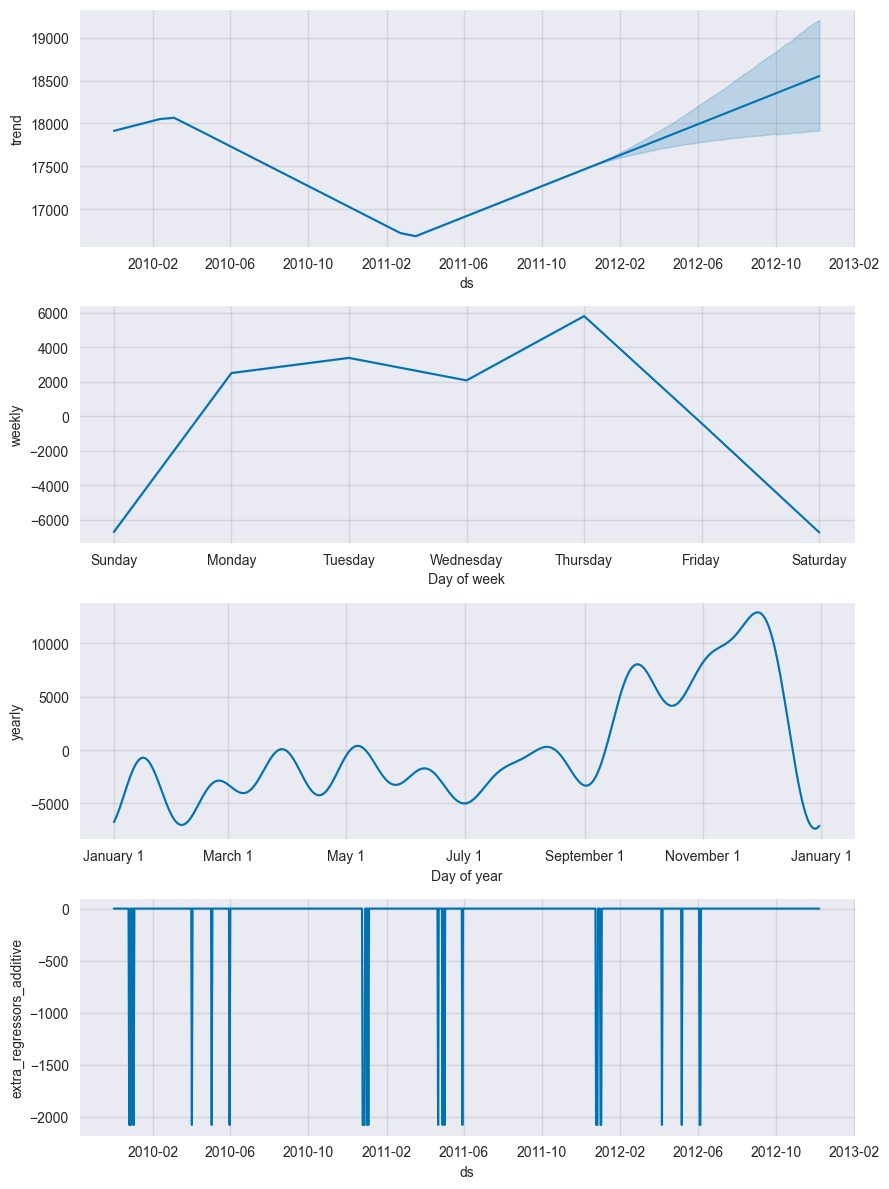

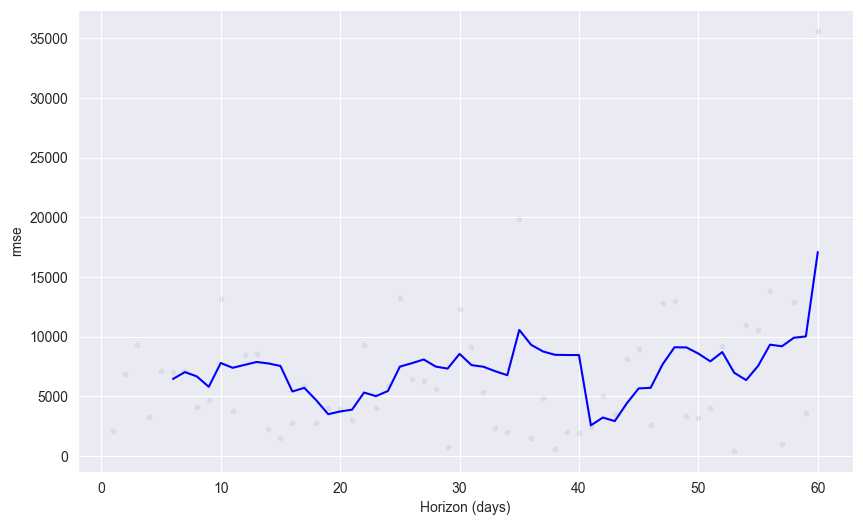

In [22]:
import itertools
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import holidays

# Function to calculate sMAPE
def smape(a, f):
    return 100 * np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

# Add is_public_holiday column
holiday = holidays.CountryHoliday('UK')
data['is_public_holiday'] = data['ds'].apply(lambda date: 1 if date in holiday else 0)

# Define model parameters
model_params = {
    'changepoint_prior_scale': 0.1,
    'seasonality_prior_scale': 1.0,
    'holidays_prior_scale': 1.0,
    'seasonality_mode': 'additive'
}

# Train the model with defined parameters
model = Prophet(**model_params)
model.add_regressor('is_public_holiday')
model.fit(data)

# Cross-validate the model
df_cv = cross_validation(model, initial='547 days', period='180 days', horizon='30 days')
df_p = performance_metrics(df_cv)

# Calculate metrics using yhat and y
mape = mean_absolute_percentage_error(df_cv['y'], df_cv['yhat'])
mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])
smape_value = smape(df_cv['y'], df_cv['yhat'])
r2 = r2_score(df_cv['y'], df_cv['yhat'])

# Output the metrics
print(f"MAPE: {round(mape, 2)}")
print(f"MAE: {round(mae, 2)}")
print(f"sMAPE: {round(smape_value, 2)}")
print(f"R²: {round(r2, 2)}")

# Forecast future values
future = model.make_future_dataframe(periods=365)
future['is_public_holiday'] = future['ds'].apply(lambda date: 1 if date in holiday else 0)

forecast = model.predict(future)

# Visualize Results
model.plot(forecast)
model.plot_components(forecast)

# Evaluate Accuracy with a longer horizon
df_cv = cross_validation(model, initial='547 days', period='180 days', horizon='60 days')
df_p = performance_metrics(df_cv)
print(df_p.head().round(2))

fig = plot_cross_validation_metric(df_cv, metric='rmse')

# Calculate metrics using yhat and y for the longer horizon
mape = mean_absolute_percentage_error(df_cv['y'], df_cv['yhat'])
mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])
smape_value = smape(df_cv['y'], df_cv['yhat'])
r2 = r2_score(df_cv['y'], df_cv['yhat'])

print(f"MAPE: {round(mape, 2)}")
print(f"MAE: {round(mae, 2)}")
print(f"sMAPE: {round(smape_value, 2)}")
print(f"R²: {round(r2, 2)}")


12:44:27 - cmdstanpy - INFO - Chain [1] start processing
12:44:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:28 - cmdstanpy - INFO - Chain [1] start processing
12:44:29 - cmdstanpy - INFO - Chain [1] done processing
12:44:29 - cmdstanpy - INFO - Chain [1] start processing
12:44:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:30 - cmdstanpy - INFO - Chain [1] start processing
12:44:30 - cmdstanpy - INFO - Chain [1] done processing
12:44:31 - cmdstanpy - INFO - Chain [1] start processing
12:44:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:32 - cmdstanpy - INFO - Chain [1] start processing
12:44:32 - cmdstanpy - INFO - Chain [1] done processing
12:44:33 - cmdstanpy - INFO - Chain [1] start processing
12:44:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:35 - cmdstanpy - INFO - Chain [1] start processing
12:44:36 - cmdstanpy - INFO - Chain [1] done processing
12:44:37 - cmdstanpy - INFO - Chain [1] start processing
12:44:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:38 - cmdstanpy - INFO - Chain [1] start processing
12:44:38 - cmdstanpy - INFO - Chain [1] done processing
12:44:39 - cmdstanpy - INFO - Chain [1] start processing
12:44:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:39 - cmdstanpy - INFO - Chain [1] start processing
12:44:39 - cmdstanpy - INFO - Chain [1] done processing
12:44:40 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing
12:44:42 - cmdstanpy - INFO - Chain [1] start processing
12:44:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:43 - cmdstanpy - INFO - Chain [1] start processing
12:44:43 - cmdstanpy - INFO - Chain [1] done processing
12:44:44 - cmdstanpy - INFO - Chain [1] start processing
12:44:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:44 - cmdstanpy - INFO - Chain [1] start processing
12:44:45 - cmdstanpy - INFO - Chain [1] done processing
12:44:45 - cmdstanpy - INFO - Chain [1] start processing
12:44:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:46 - cmdstanpy - INFO - Chain [1] start processing
12:44:46 - cmdstanpy - INFO - Chain [1] done processing
12:44:47 - cmdstanpy - INFO - Chain [1] start processing
12:44:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:47 - cmdstanpy - INFO - Chain [1] start processing
12:44:48 - cmdstanpy - INFO - Chain [1] done processing
12:44:48 - cmdstanpy - INFO - Chain [1] start processing
12:44:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:49 - cmdstanpy - INFO - Chain [1] start processing
12:44:49 - cmdstanpy - INFO - Chain [1] done processing
12:44:49 - cmdstanpy - INFO - Chain [1] start processing
12:44:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:50 - cmdstanpy - INFO - Chain [1] start processing
12:44:50 - cmdstanpy - INFO - Chain [1] done processing
12:44:51 - cmdstanpy - INFO - Chain [1] start processing
12:44:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:52 - cmdstanpy - INFO - Chain [1] start processing
12:44:52 - cmdstanpy - INFO - Chain [1] done processing
12:44:53 - cmdstanpy - INFO - Chain [1] start processing
12:44:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:54 - cmdstanpy - INFO - Chain [1] start processing
12:44:54 - cmdstanpy - INFO - Chain [1] done processing
12:44:54 - cmdstanpy - INFO - Chain [1] start processing
12:44:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:55 - cmdstanpy - INFO - Chain [1] start processing
12:44:56 - cmdstanpy - INFO - Chain [1] done processing
12:44:56 - cmdstanpy - INFO - Chain [1] start processing
12:44:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:57 - cmdstanpy - INFO - Chain [1] start processing
12:44:57 - cmdstanpy - INFO - Chain [1] done processing
12:44:58 - cmdstanpy - INFO - Chain [1] start processing
12:44:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:44:58 - cmdstanpy - INFO - Chain [1] start processing
12:44:58 - cmdstanpy - INFO - Chain [1] done processing
12:44:59 - cmdstanpy - INFO - Chain [1] start processing
12:44:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:01 - cmdstanpy - INFO - Chain [1] start processing
12:45:02 - cmdstanpy - INFO - Chain [1] done processing
12:45:04 - cmdstanpy - INFO - Chain [1] start processing
12:45:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:04 - cmdstanpy - INFO - Chain [1] start processing
12:45:05 - cmdstanpy - INFO - Chain [1] done processing
12:45:05 - cmdstanpy - INFO - Chain [1] start processing
12:45:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:06 - cmdstanpy - INFO - Chain [1] start processing
12:45:07 - cmdstanpy - INFO - Chain [1] done processing
12:45:08 - cmdstanpy - INFO - Chain [1] start processing
12:45:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:09 - cmdstanpy - INFO - Chain [1] start processing
12:45:09 - cmdstanpy - INFO - Chain [1] done processing
12:45:10 - cmdstanpy - INFO - Chain [1] start processing
12:45:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:10 - cmdstanpy - INFO - Chain [1] start processing
12:45:11 - cmdstanpy - INFO - Chain [1] done processing
12:45:11 - cmdstanpy - INFO - Chain [1] start processing
12:45:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:12 - cmdstanpy - INFO - Chain [1] start processing
12:45:12 - cmdstanpy - INFO - Chain [1] done processing
12:45:12 - cmdstanpy - INFO - Chain [1] start processing
12:45:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:13 - cmdstanpy - INFO - Chain [1] start processing
12:45:13 - cmdstanpy - INFO - Chain [1] done processing
12:45:14 - cmdstanpy - INFO - Chain [1] start processing
12:45:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:14 - cmdstanpy - INFO - Chain [1] start processing
12:45:14 - cmdstanpy - INFO - Chain [1] done processing
12:45:15 - cmdstanpy - INFO - Chain [1] start processing
12:45:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:16 - cmdstanpy - INFO - Chain [1] start processing
12:45:17 - cmdstanpy - INFO - Chain [1] done processing
12:45:17 - cmdstanpy - INFO - Chain [1] start processing
12:45:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:18 - cmdstanpy - INFO - Chain [1] start processing
12:45:18 - cmdstanpy - INFO - Chain [1] done processing
12:45:18 - cmdstanpy - INFO - Chain [1] start processing
12:45:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:19 - cmdstanpy - INFO - Chain [1] start processing
12:45:19 - cmdstanpy - INFO - Chain [1] done processing
12:45:20 - cmdstanpy - INFO - Chain [1] start processing
12:45:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing
12:45:22 - cmdstanpy - INFO - Chain [1] start processing
12:45:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:23 - cmdstanpy - INFO - Chain [1] start processing
12:45:23 - cmdstanpy - INFO - Chain [1] done processing
12:45:23 - cmdstanpy - INFO - Chain [1] start processing
12:45:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:24 - cmdstanpy - INFO - Chain [1] start processing
12:45:25 - cmdstanpy - INFO - Chain [1] done processing
12:45:25 - cmdstanpy - INFO - Chain [1] start processing
12:45:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:26 - cmdstanpy - INFO - Chain [1] start processing
12:45:26 - cmdstanpy - INFO - Chain [1] done processing
12:45:27 - cmdstanpy - INFO - Chain [1] start processing
12:45:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:27 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing
12:45:28 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:29 - cmdstanpy - INFO - Chain [1] start processing
12:45:29 - cmdstanpy - INFO - Chain [1] done processing
12:45:30 - cmdstanpy - INFO - Chain [1] start processing
12:45:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:31 - cmdstanpy - INFO - Chain [1] start processing
12:45:31 - cmdstanpy - INFO - Chain [1] done processing
12:45:32 - cmdstanpy - INFO - Chain [1] start processing
12:45:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:32 - cmdstanpy - INFO - Chain [1] start processing
12:45:33 - cmdstanpy - INFO - Chain [1] done processing
12:45:33 - cmdstanpy - INFO - Chain [1] start processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:34 - cmdstanpy - INFO - Chain [1] start processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing
12:45:35 - cmdstanpy - INFO - Chain [1] start processing
12:45:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:36 - cmdstanpy - INFO - Chain [1] start processing
12:45:36 - cmdstanpy - INFO - Chain [1] done processing
12:45:36 - cmdstanpy - INFO - Chain [1] start processing
12:45:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:37 - cmdstanpy - INFO - Chain [1] start processing
12:45:37 - cmdstanpy - INFO - Chain [1] done processing
12:45:38 - cmdstanpy - INFO - Chain [1] start processing
12:45:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:39 - cmdstanpy - INFO - Chain [1] start processing
12:45:39 - cmdstanpy - INFO - Chain [1] done processing
12:45:40 - cmdstanpy - INFO - Chain [1] start processing
12:45:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:41 - cmdstanpy - INFO - Chain [1] start processing
12:45:41 - cmdstanpy - INFO - Chain [1] done processing
12:45:42 - cmdstanpy - INFO - Chain [1] start processing
12:45:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:43 - cmdstanpy - INFO - Chain [1] start processing
12:45:44 - cmdstanpy - INFO - Chain [1] done processing
12:45:44 - cmdstanpy - INFO - Chain [1] start processing
12:45:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:45 - cmdstanpy - INFO - Chain [1] start processing
12:45:45 - cmdstanpy - INFO - Chain [1] done processing
12:45:46 - cmdstanpy - INFO - Chain [1] start processing
12:45:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:47 - cmdstanpy - INFO - Chain [1] start processing
12:45:47 - cmdstanpy - INFO - Chain [1] done processing
12:45:48 - cmdstanpy - INFO - Chain [1] start processing
12:45:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:49 - cmdstanpy - INFO - Chain [1] start processing
12:45:49 - cmdstanpy - INFO - Chain [1] done processing
12:45:50 - cmdstanpy - INFO - Chain [1] start processing
12:45:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:53 - cmdstanpy - INFO - Chain [1] start processing
12:45:54 - cmdstanpy - INFO - Chain [1] done processing
12:45:55 - cmdstanpy - INFO - Chain [1] start processing
12:45:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:56 - cmdstanpy - INFO - Chain [1] start processing
12:45:56 - cmdstanpy - INFO - Chain [1] done processing
12:45:57 - cmdstanpy - INFO - Chain [1] start processing
12:45:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:45:58 - cmdstanpy - INFO - Chain [1] start processing
12:45:58 - cmdstanpy - INFO - Chain [1] done processing
12:45:59 - cmdstanpy - INFO - Chain [1] start processing
12:45:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:46:00 - cmdstanpy - INFO - Chain [1] start processing
12:46:00 - cmdstanpy - INFO - Chain [1] done processing
12:46:01 - cmdstanpy - INFO - Chain [1] start processing
12:46:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:46:02 - cmdstanpy - INFO - Chain [1] start processing
12:46:02 - cmdstanpy - INFO - Chain [1] done processing
12:46:03 - cmdstanpy - INFO - Chain [1] start processing
12:46:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:46:03 - cmdstanpy - INFO - Chain [1] start processing
12:46:04 - cmdstanpy - INFO - Chain [1] done processing
12:46:04 - cmdstanpy - INFO - Chain [1] start processing
12:46:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:46:05 - cmdstanpy - INFO - Chain [1] start processing
12:46:05 - cmdstanpy - INFO - Chain [1] done processing
12:46:06 - cmdstanpy - INFO - Chain [1] start processing
12:46:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:46:07 - cmdstanpy - INFO - Chain [1] start processing
12:46:07 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}
Best MAPE: 0.28
Best MAE: 6848.5
Best sMAPE: 24.28
Best R²: 0.2


12:46:08 - cmdstanpy - INFO - Chain [1] start processing
12:46:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

12:46:12 - cmdstanpy - INFO - Chain [1] start processing
12:46:12 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0  6 days  35414815.44  5951.03  5527.77  0.42   0.40   0.33      1.00
1  7 days  44512930.63  6671.80  6397.38  0.45   0.40   0.36      1.00
2  8 days  41844281.48  6468.72  6155.67  0.41   0.35   0.34      1.00
3  9 days  31827132.97  5641.55  5364.27  0.37   0.23   0.31      1.00
4 10 days  62783960.45  7923.63  7237.33  0.41   0.29   0.36      0.83
MAPE: 0.3
MAE: 6555.1
sMAPE: 26.97
R²: 0.28


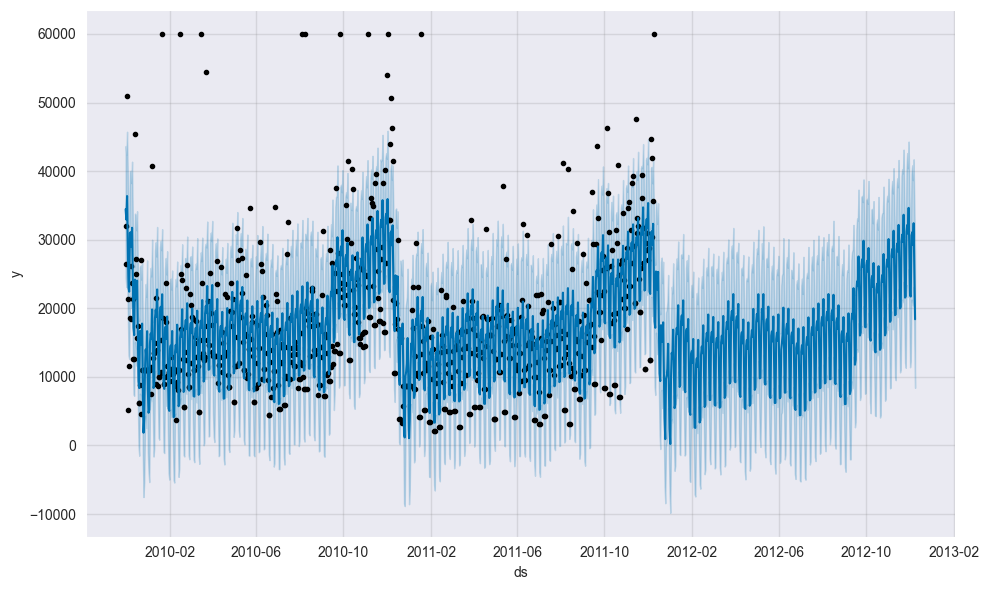

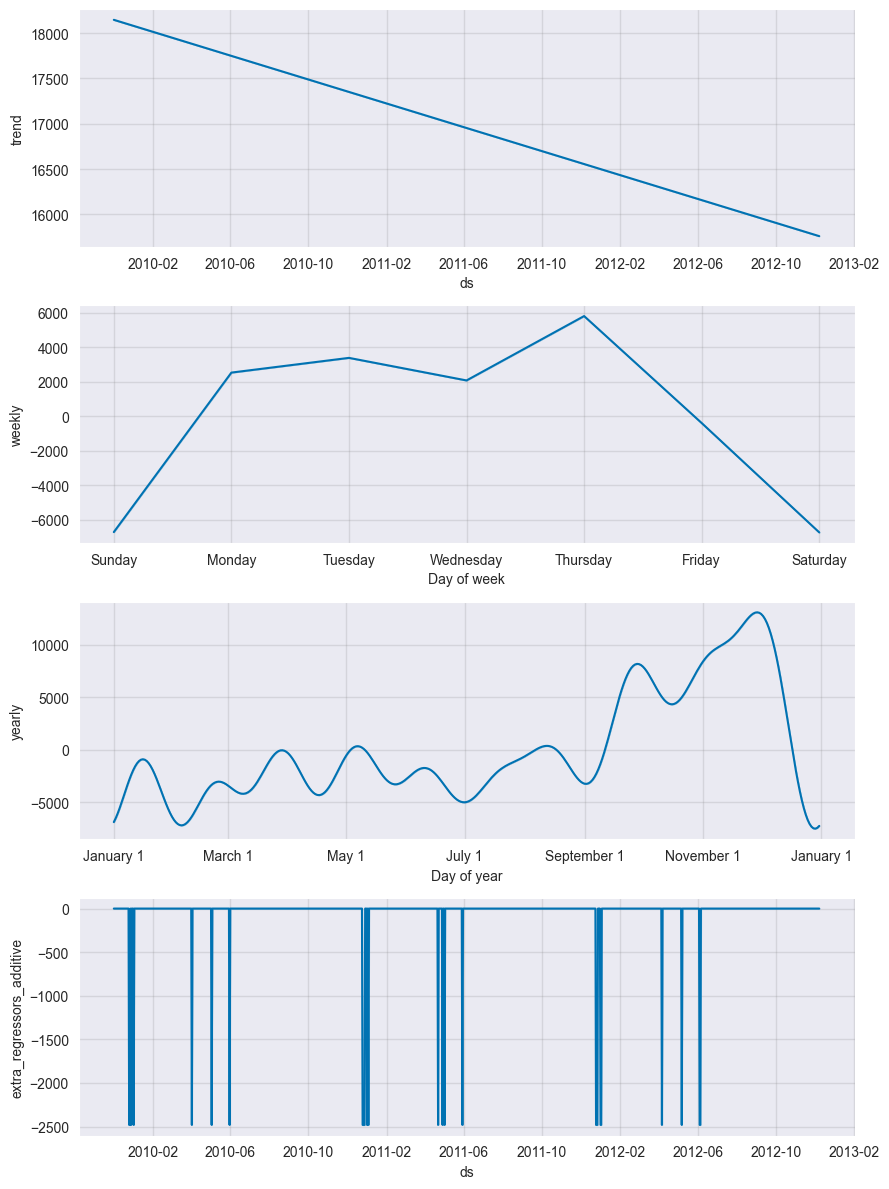

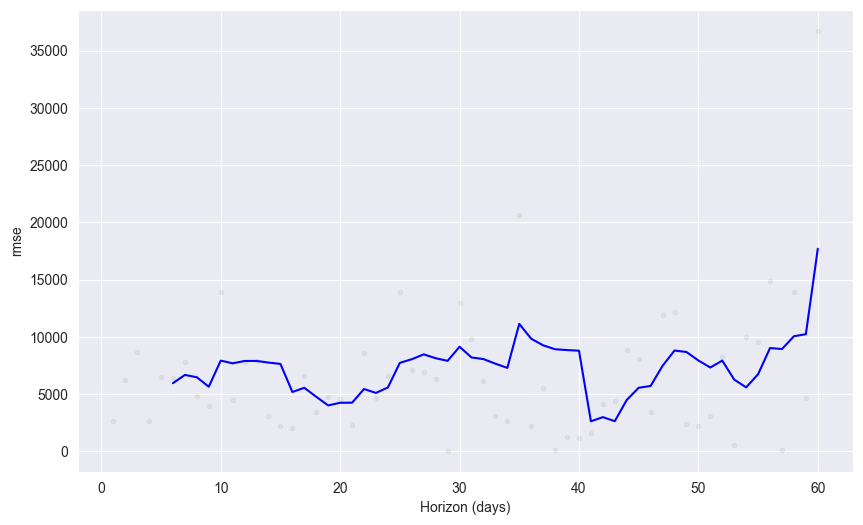

In [21]:
import itertools
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import holidays

# Function to calculate sMAPE
def smape(a, f):
    return 100 * np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

# Add is_public_holiday column
holiday = holidays.CountryHoliday('UK')
data['is_public_holiday'] = data['ds'].apply(lambda date: 1 if date in holiday else 0)

# Define hyperparameters to tune
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

best_params = None
best_mape = float('inf')
best_mae = float('inf')
best_smape = float('inf')
best_r2 = float('-inf')

# Grid search to find the best hyperparameters
for params in all_params:
    model = Prophet(**params)
    model.add_regressor('is_public_holiday')
    model.fit(data)

    # Cross-validate the model
    df_cv = cross_validation(model, initial='547 days', period='180 days', horizon='30 days')
    df_p = performance_metrics(df_cv)
    
    # Calculate metrics
    mape = mean_absolute_percentage_error(df_cv['y'], df_cv['yhat'])
    mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])
    smape_value = smape(df_cv['y'], df_cv['yhat'])
    r2 = r2_score(df_cv['y'], df_cv['yhat'])
    
    if mape < best_mape:
        best_mape = mape
        best_mae = mae
        best_smape = smape_value
        best_r2 = r2
        best_params = params

# Output the best parameters and metrics
print(f"Best Parameters: {best_params}")
print(f"Best MAPE: {round(best_mape, 2)}")
print(f"Best MAE: {round(best_mae, 2)}")
print(f"Best sMAPE: {round(best_smape, 2)}")
print(f"Best R²: {round(best_r2, 2)}")

# Train the final model with the best parameters
model = Prophet(**best_params)
model.add_regressor('is_public_holiday')
model.fit(data)

# Forecast future values
future = model.make_future_dataframe(periods=365)
future['is_public_holiday'] = future['ds'].apply(lambda date: 1 if date in holiday else 0)

forecast = model.predict(future)

# Visualize Results
model.plot(forecast)
model.plot_components(forecast)

# Evaluate Accuracy
df_cv = cross_validation(model, initial='547 days', period='180 days', horizon='60 days')
df_p = performance_metrics(df_cv)
print(df_p.head().round(2))

fig = plot_cross_validation_metric(df_cv, metric='rmse')

# Calculate metrics using yhat and y
mape = mean_absolute_percentage_error(df_cv['y'], df_cv['yhat'])
mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])
smape_value = smape(df_cv['y'], df_cv['yhat'])
r2 = r2_score(df_cv['y'], df_cv['yhat'])

print(f"MAPE: {round(mape, 2)}")
print(f"MAE: {round(mae, 2)}")
print(f"sMAPE: {round(smape_value, 2)}")
print(f"R²: {round(r2, 2)}")
